# Machine Learning
- This notebook studies the determinants of access to financial markets using machine learning methods.
- The primary differences from [Financial](./03_financial.ipynb) is that the dataset is split into testing and training datasets to avoid overfitting.

### Findings
- I use three machine learning classifiers: random forest, ridge regression, and XGBoost.
- I find the most important predicts of access to financial markets are a mix of income, education, career, and location.
- The machine learning models succeed at predicting access to financial markets, but struggle to identify who *does not* have access to financial markets.

In [115]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as sm

import os
home = os.path.expanduser('~')
import sys; sys.path.append(home + '/github/access-to-financial-markets/src/')

In [116]:
raw     = home + '/Dropbox/data/mexico_fls/raw/2005/'
processed = home + '/Dropbox/data/mexico_fls/processed2/'

figs    = home + '/github/access-to-financial-markets/fig/'
dicts   = home + '/github/access-to-financial-markets/notebooks/dicts/'

In [117]:
df = pd.read_csv(processed + 'data.csv')
df

,hhid,hhmember,weight_ind,is_hhm,age,attended_school,education,sex,income_type,income_undetailed,...,hh_has_savings_afores,hh_has_savings_solidarity,hh_has_savings_at_house,hh_has_savings_other,hh_has_debts_12mth,hh_debts_12mth,hh_has_savings,weight,income_decile,income_quartile
0,1000,1,2244.0,1.0,41.0,1.0,Medium,Male,dk,NaN,...,False,False,False,False,0.0,0.0,False,1908.0,5,2
1,3000,1,2244.0,1.0,45.0,0.0,Low,Male,undetailed,6000.0,...,False,False,False,False,0.0,0.0,False,1908.0,1,1
2,8000,1,2244.0,1.0,33.0,1.0,High,Male,undetailed,60000.0,...,False,False,False,False,1.0,15000.0,True,1908.0,8,3
3,11000,1,2074.0,1.0,29.0,1.0,Medium,Male,detailed,NaN,...,False,False,False,False,0.0,0.0,False,1763.0,7,3
4,12000,1,2074.0,1.0,46.0,1.0,Low,Male,undetailed,48000.0,...,False,False,False,False,0.0,0.0,True,1763.0,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,10751000,1,5539.0,1.0,39.0,1.0,Low,Male,undetailed,5000.0,...,False,False,False,False,1.0,12000.0,False,4119.0,1,1
3691,10752000,1,1614.0,1.0,32.0,1.0,Medium,Male,undetailed,60000.0,...,False,False,False,False,1.0,7000.0,False,1286.0,7,3
3692,10754000,1,817.0,1.0,43.0,1.0,Low,Male,undetailed,59000.0,...,False,False,False,False,1.0,1500.0,False,650.0,7,3
3693,10758000,1,839.0,1.0,27.0,1.0,Low,Male,undetailed,36000.0,...,False,False,False,False,0.0,0.0,False,668.0,5,2


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3695 entries, 0 to 3694
Data columns (total 100 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hhid                               3695 non-null   int64  
 1   hhmember                           3695 non-null   int64  
 2   weight_ind                         3695 non-null   float64
 3   is_hhm                             3695 non-null   float64
 4   age                                3695 non-null   float64
 5   attended_school                    3694 non-null   float64
 6   education                          3695 non-null   object 
 7   sex                                3695 non-null   object 
 8   income_type                        2555 non-null   object 
 9   income_undetailed                  2038 non-null   float64
 10  has_income_second_job              3695 non-null   float64
 11  income_second_job                  52 non-null     floa

In [119]:
# target variable
y = df['included']

# blank dataframe to input machine learning encoded data
X = pd.DataFrame(index=df.index)

## Encoding

In [120]:
education                = pd.get_dummies(df[['education']], prefix='education', drop_first=True)
hh_size                  = pd.get_dummies(df[['hh_size']], prefix='hh_size', drop_first=True)
state                    = pd.get_dummies(df[['state']], prefix='state', drop_first=True)
naics                    = pd.get_dummies(df[['naics']], prefix='naics', drop_first=True)
sex                      = pd.get_dummies(df[['sex']], prefix='sex', drop_first=True)
has_income_main_business = pd.get_dummies(df[['has_income_main_business']], prefix='has_income_main_business')

In [121]:
X = pd.concat([education, hh_size, state, naics, sex, has_income_main_business], axis=1)

In [122]:
from sklearn.preprocessing import  StandardScaler

X['income']    = StandardScaler().fit_transform(df[['income']])
X['income_sq'] = StandardScaler().fit_transform(df[['income_sq']])
X['age']       = StandardScaler().fit_transform(df[['age']])
X['age_sq']    = StandardScaler().fit_transform(df[['age_sq']])

In [123]:
X

,education_Low,education_Medium,hh_size,state_Coahuila,state_Durango,state_Federal District,state_Guanajuato,state_Jalisco,state_Michoacan,state_Morelos,...,naics_Retail,naics_Transportation,naics_Utilities,naics_Wholesale,sex_Male,has_income_main_business,income,income_sq,age,age_sq
0,False,True,2,False,False,False,False,False,False,False,...,False,False,False,False,True,True,-0.306242,-0.146748,-0.382823,-0.477195
1,True,False,5,False,False,False,False,False,False,False,...,False,False,False,False,True,True,-0.853955,-0.280889,0.001456,-0.113203
2,False,False,2,False,False,False,False,False,False,False,...,True,False,False,False,True,False,0.184175,0.147491,-1.151381,-1.103600
3,False,True,2,False,False,False,False,False,False,False,...,False,False,False,False,True,False,-0.082372,-0.032841,-1.535660,-1.366012
4,True,False,1,False,False,False,False,False,False,False,...,False,False,False,False,True,False,-0.264746,-0.128223,0.097526,-0.016915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,True,False,3,False,False,False,False,False,False,False,...,True,False,False,False,True,False,-0.867984,-0.281630,-0.574963,-0.646494
3691,False,True,2,False,False,False,False,False,False,False,...,False,False,False,False,True,False,-0.096400,-0.040986,-1.247451,-1.172377
3692,True,False,2,False,False,False,False,False,False,False,...,True,False,False,False,True,False,-0.110429,-0.048996,-0.190684,-0.299432
3693,True,False,2,False,False,False,False,False,False,False,...,False,False,False,False,True,False,-0.433091,-0.196075,-1.727800,-1.484521


In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [125]:
# split model into tresting and training datasets
# use stratified KFold to ensure both training and test datasets have same proportion of household with access to financial markets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Models

In [126]:
best = {}
predictions = {}

### Random Forest

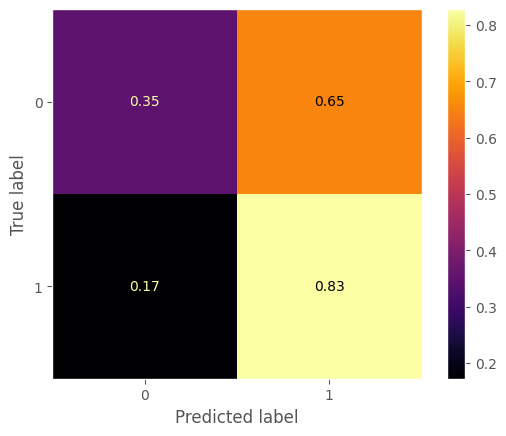

In [127]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [2, 5, 7, 9]
}
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy')
grid_clf.fit(X_train, y_train)

rfc_best = grid_clf.best_estimator_
best['Random Forest Classifier'] = rfc_best
predictions['Random Forest Classifier'] = rfc_best.predict(X_test)

cm = confusion_matrix(y_test, predictions['Random Forest Classifier'], normalize='true')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='inferno')
plt.grid(False)
plt.show();

In [128]:
features = pd.DataFrame()
features['variable'] = X.columns
features['importance'] = rfc_best.feature_importances_
features.sort_values(by='importance', ascending=False, inplace=True)

### Random Forest - Feature Importance

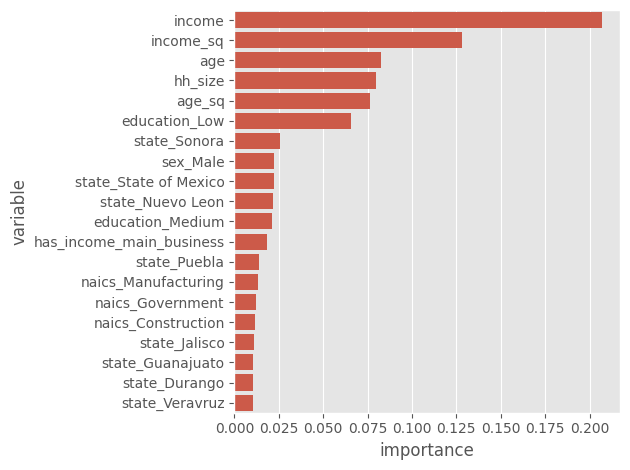

In [129]:
sns.barplot(features.query('importance > 0.01'), x='importance', y='variable', orient='h')
plt.tight_layout()

### XGBoost

In [130]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    objective='binary:logistic'
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 15,
    verbose=True
)

grid_search.fit(X_train, y_train)


Fitting 15 folds for each of 96 candidates, totalling 1440 fits


GridSearchCV(cv=15,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='accuracy', verbose=True)

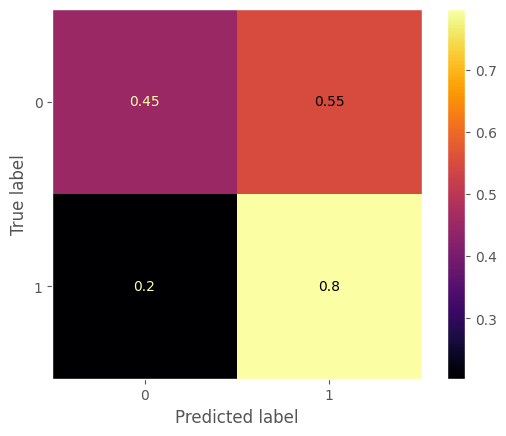

In [131]:
xgb_best = grid_search.best_estimator_

best['XGBoost'] = xgb_best
predictions['XGBoost'] = xgb_best.predict(X_test)

cm = confusion_matrix(y_test, predictions['XGBoost'], normalize='true')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='inferno')
plt.grid(False)
plt.show();

### XGBoost - Feature Importance
- The below graph plots xgboosts feature importance attributes
- The most important variables are industry, income, education, and location
- Compared to the random forest classifier, age plays a smaller role

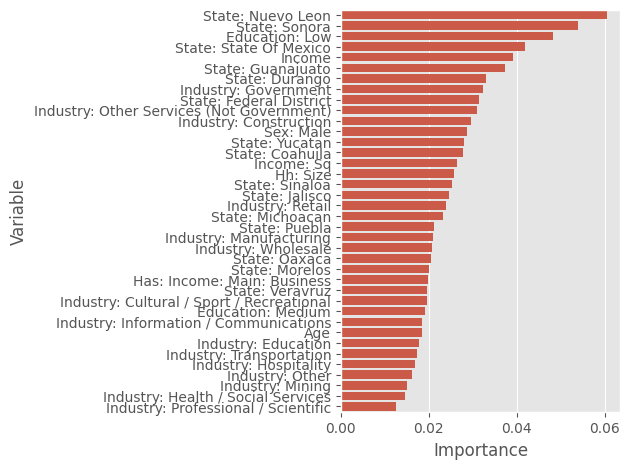

In [132]:
features = pd.DataFrame()
features['variable'] = X.columns
features['importance'] = xgb_best.feature_importances_
features.sort_values('importance', ascending=False, inplace=True)
features['variable'] = features['variable'].str.replace('naics', 'industry')
features['variable'] = features['variable'].str.replace('_', ': ')
features['variable'] = features['variable'].str.title()

sns.barplot(features.query('importance > 0'), y='variable', x='importance', orient='h')
plt.xlabel('importance'.title())
plt.ylabel('variable'.title())

plt.tight_layout()

plt.savefig('../../fig/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')


## Ridge Regression

Fitting 15 folds for each of 15 candidates, totalling 225 fits


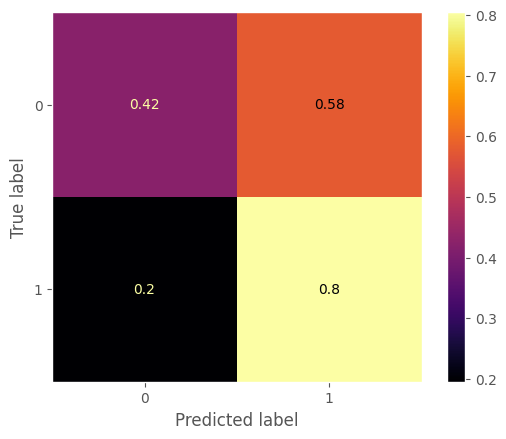

In [133]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()

parameters = {
    "alpha" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
}

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 15,
    verbose=True
)

grid_search.fit(X_train, y_train)
ridge_best = grid_search.best_estimator_

best['Ridge Regression'] = ridge_best
predictions['Ridge Regression'] = ridge_best.predict(X_test)

cm = confusion_matrix(y_test, predictions['Ridge Regression'], normalize='true')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap='inferno')
plt.grid(False)
plt.show();

## Metrics

In [134]:
from sklearn.metrics import precision_recall_fscore_support
models = ['Random Forest Classifier', 'XGBoost', 'Ridge Regression']
stats = pd.DataFrame()
stats.index = ['Precision', 'Recall', 'F1']

for model in models:
    stats[model] = precision_recall_fscore_support(y_test, predictions[model], average='binary')[:3]
stats = stats.reset_index(names='Metric')

stats = stats.melt(id_vars='Metric', var_name = 'Model', value_name='Score')

In [135]:
stats

,Metric,Model,Score
0,Precision,Random Forest Classifier,0.654286
1,Recall,Random Forest Classifier,0.828210
2,F1,Random Forest Classifier,0.731045
3,Precision,XGBoost,0.683721
4,Recall,XGBoost,0.797468
5,F1,XGBoost,0.736227
6,Precision,Ridge Regression,0.675266
7,Recall,Ridge Regression,0.804702
8,F1,Ridge Regression,0.734323


### Scores
- This figure plots the precision, recall, and F1 for each model.
- The random forest classifier does best for recall and F1, whereas ridge regression has a slight advantage for precision.

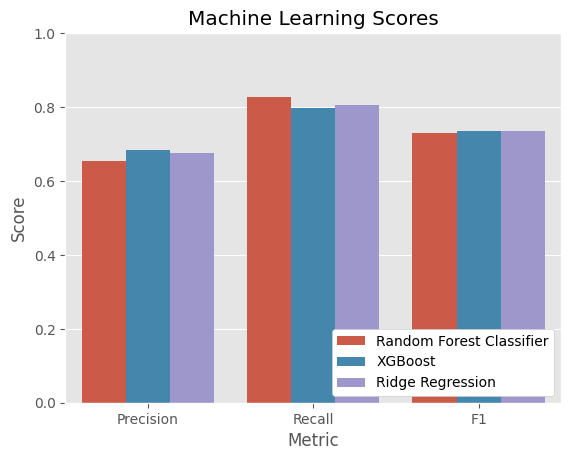

In [136]:
sns.barplot(stats, x='Metric', y='Score', hue='Model')
plt.ylim(0, 1)
plt.legend(loc = 'lower right', facecolor='white', framealpha=1)
plt.title('Machine Learning Scores')

plt.savefig('../../fig/machine_learning_scores.png', 
            bbox_inches='tight', dpi=300)